# Projeto 1 - MC886

## Objetivo
Aplicar métodos de Aprendizado Não Supervisionado para resolver problemas de clusterização e redução de dimensionalidade em duas tarefas:
<ul>
    <li>Uma tarefa 2D (utilizando os dados fornecidos)</li>
    <li>Uma tarefa com mais dimensões especificada pelo grupo (sendo necessário descrever o problema escolhido, as features utilizadas e o tamanho do dataset)</li>

## Parte 1 - Métodos de Clusterização
Nesta tarefa, implementamos os algoritmos K-Means e **X** utilizando os conceitos dados em aula e outras referências.
Após a implementação, nos organizamos para treinar nosso modelo, e realizamos os seguintes procedimentos:
<ul>
    <li>Normalizamos os dados para tratar as diferenças de escala entre nossas features</li>
    <li>Separamos nosso conjunto de dados entre treino e teste (90/10)</li>
    <li>Treinamos os métodos na tarefa 2D com os dados fornecidos</li>
    <li>Treinamos os métodos na tarefa selecionada pelo grupo</li>
    <li>Avaliamos números diferentes de clusteres nas tarefas, e seu impacto para escolher a melhor configuração para nossos modelos </li>
    <li>Utilizamos métricas apropriadas para avaliar os experimentos</li>
    <li>Escolhemos os melhores modelos e aplicamos os dados de testes. Mostramos para quais clusteres os novos dados foram designados</li>
</ul>


### Tarefa selecionada
&emsp;Para esta tarefa escolhemos o problema que envolve resultados uma análise química de vinhos, cultivados numa mesma região da Itália mas que derivam de 3 vinículas diferentes.\
&emsp;A análise determina as quantidades de 13 constituentes encontrados nos vinhos, que são:\
&emsp;&emsp;&emsp;Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315, Proline.\
    Fonte: https://towardsdatascience.com/k-means-clustering-of-wine-data-95bac074baae        
    Dataset disponivel no Kaggle: https://www.kaggle.com/harrywang/wine-dataset-for-clustering

In [3]:
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from random import *
import pandas as pd
import sys
from scipy.cluster.hierarchy import dendrogram

# Separar dataset entre treino e teste

# importa dataset cluster.dat
def import_dataset():
    with open('cluster.dat') as binary_file:
        data = []
        x = []
        y = []
        for d in binary_file:
            string = d.split()
            x.append(float(string[0]))
            y.append(float(string[1]))
    array = np.ndarray(shape=(len(x), 2), dtype=float)
    for i in range(len(x)):
        array[i][0] = x[i]
        array[i][1] = y[i]
    return array




def import_wine_dataset():
    wine_names = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', \
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315',\
                  'Proline']
    wine_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', names = wine_names) 
    wine_df = pd.DataFrame(wine_data)
    wine_df.Class = wine_df.Class - 1 # formata a coluna "Class"

    # wine_df.plot.scatter(x = 'Alcohol', y = 'OD280/OD315', c= 'Class', figsize=(12,8), colormap='jet')
    # show()
    # print(wine_df.to_numpy())
    X_wine = wine_df[['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', \
                  'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315',\
                  'Proline']]
    Y_wine = wine_df[['Class']]
    return X_wine.to_numpy(), X_wine.to_numpy()

In [6]:
# Normaliza dados dos dois datasets

X_array = import_dataset()
W_array_x, W_array_y = import_wine_dataset()

scaler = StandardScaler()

scaler.fit(X_array)
scaler.mean_
X_array = scaler.transform(X_array)

scaler.fit(W_array_x)
scaler.mean_
W_array_x = scaler.transform(W_array_x)

In [7]:
# Separa dataset entre dados de treino e teste ( 90/10 )

X_treino, X_teste = train_test_split(X_array, test_size=0.1, random_state=42)
print(X_treino.shape)
print(X_teste.shape)

W_treino, W_teste, W_treino_y, W_teste_y = train_test_split(W_array_x, W_array_y, test_size=0.1, random_state=42)
print(W_treino.shape)
print(W_treino_y.shape)
print(W_teste.shape)
print(W_teste_y.shape)

(515, 2)
(58, 2)
(160, 13)
(160, 13)
(18, 13)
(18, 13)


### Implementação do algoritimo K-Means 

In [27]:
# funcao para calcular distancia euclidiana
def euclideanDistance(p, q):
    soma = 0
    for i in range(len(p)):
        soma += (p[i] - q[i])**2
    return np.sqrt(soma)

# funcao para calcular a qual cluster um ponto pertence
def getClusterMap(k, centroids, array):
    #initialize cluster_map
    cluster_map = {}
    for i in range(k):
        cluster_map[i] = []
    
    for p in array:
        min_dist = -1
        cluster = -1
        for c in range(len(centroids)):
            c_xy = centroids[c]
            distance = euclideanDistance(c_xy, p)
            if (min_dist == -1) or (distance < min_dist):
                min_dist = distance
                cluster = c
        cluster_map[cluster].append(p)
    
    return cluster_map

# funcao para atualizar os centroides
def getNewCentroids(clusterMap):
    new_centroids = []
    for c in clusterMap:
        points = clusterMap[c]
        
        min_sum_dist = -1
        for i in range(len(points)):
            sum_dist = 0
            for j in range(len(points)):
                sum_dist += euclideanDistance(points[i], points[j])
                
            if (min_sum_dist == -1) or (sum_dist < min_sum_dist):
                new_centroid = points[i]
                min_sum_dist = sum_dist
        new_centroids.append(new_centroid)
    
    return new_centroids
        
#funcao para plotar graficos com clusteres
def plotCluster(clusterMap):
    for c in clusterMap:
        points = clusterMap[c]
        array = np.ndarray(shape=(len(points), 2), dtype=float)
        for i in range(len(points)):
            array[i][0] = points[i][0]
            array[i][1] = points[i][1]
            
        plt.scatter(array[:,0], array[:,1])
    plt.show()
    
# funcao para exibir os pontos que são centroides
def printCentroids(k, centroids):
    for i in range(k):
        centroid = centroids[i]
        print(centroid)
        

def D(x, centers):
    dists = []

    for c in centers:
        dists.append(euclideanDistance(x, c))

    return np.amin(dists)

def plusPlusInitialization(k, points):
    # D(x) menor distancia ao centro mais prox
    # prob = D(x) / sum (D(x) ** 2)
    centroids = []
    # 1 - escolher 1 centro aleatoriamente
    centroids.append(points[randrange(len(points))])

    # 2 - pra cada nao escolhido calcular D(x) e a prob
    for n in range(k - 1):
        min_dist_acc = 0
        probabilities = []
        Ds = []
        for p in points:
            d = D(p, centroids)
            min_dist_acc += d ** 2
            Ds.append(d)
        for d in Ds:    
            probabilities.append(d / min_dist_acc)
        # 3 - Escolher outro ponto usando a função de prob proporcional a D(x)² - distante dos 
        #     outros centros mais prox
        centroids.append(
            points[
                np.random.choice(len(points), size = 1, p = probabilities/np.sum(probabilities))[0]
            ]
        )
        
    # 4 retornar centroides
    return centroids
    
def kmeans(k, array, n_iter=5, mode='train', fixed_centroids=[], print_info=True):
    if mode == 'train':
    # initialize centroids
        centroids = plusPlusInitialization(k, array)

        # Conseguimos uma lista com 'k' pontos para servirem de centroides iniciais
        for n in range(n_iter):
            # calculamos os clusters
            if print_info:
                printCentroids(k, centroids)
            clusterMap = getClusterMap(k, centroids, array)

            # atualizaremos nossos centroids a partir da media das dist euclid
            centroids = getNewCentroids(clusterMap)
            if print_info:
                plotCluster(clusterMap)
        clusterMap = getClusterMap(k, centroids, array)
        if print_info:
            plotCluster(clusterMap)
        return centroids,clusterMap
    if mode == 'test':
        clusterMap = getClusterMap(k, fixed_centroids, array)
        if print_info:
            plotCluster(clusterMap)
    
    
    

### Implementação do algoritmo Agglomerative Hierarchical Clustering

In [57]:
def initializeClusterMap(points):
    clusterMap = {}
    for i in range(len(points)):
        clusterMap[i] = i
    return clusterMap

def initializePointsMap(points):
    pointsMap = {}
    for i in range(len(points)):
        pointsMap[i] = [i]
    return pointsMap

def initializeDistances(points):
    distances = np.empty((len(points), len(points)))
    for i in range(len(points)):
        for j in range(len(points)):
            distances[i][j] = euclideanDistance(points[i], points[j])

    return distances
    
# pi e pj sao indices dos pontos no array
def mergeCluster(clusterMap, pointsMap, pi, pj, n):
    ci = clusterMap[pi]
    cj = clusterMap[pj]

    size = len(clusterMap)
    index = size + (size-n)

    for c in clusterMap:
        if clusterMap[c] == cj or clusterMap[c] == ci:
            clusterMap[c] = index

    #atualiza pointsMap
    ci_pts = pointsMap[ci]
    cj_pts = pointsMap[cj]
    pointsMap.pop(ci)
    pointsMap.pop(cj)
    pointsMap[index] = ci_pts + cj_pts
            
    return clusterMap, pointsMap

def updateDistance(distances, pointsMap, points, new_cluster, mode):
    # preciso atualizar a distancia entre on clusteres
    #   mas eh entre o CLUSTERES, nao os pontos. Entao como?
    if mode == "singular":
        return distances
    elif mode == "complete":
        pts = pointsMap[new_cluster]
        # computar a distancia entre o novo cluster e cada cluster
        for c in pointsMap:
            #distancia maxima entre os pontos de pointsMap[c] e pts
            if c != new_cluster:
                dist = []
                for p in pts:
                    for q in pointsMap[c]:
                        dist.append(euclideanDistance(points[p], points[q]))
                for p in pts:
                    for q in pointsMap[c]:
                        distances[p][q] = max(dist)
                        distances[q][p] = max(dist)

    elif mode == "average":
        pts = pointsMap[new_cluster]
        # computar a distancia entre o novo cluster e cada cluster
        for c in pointsMap:
            #distancia media entre os pontos de pointsMap[c] e pts
            if c != new_cluster:
                dist = []
                for p in pts:
                    for q in pointsMap[c]:
                        dist.append(euclideanDistance(points[p], points[q]))
                average = sum(np.array(dist)/(len(pts)*len(pointsMap[c])))
                for p in pts:
                    for q in pointsMap[c]:
                        distances[p][q] = average
                        distances[q][p] = average
                        
    return distances


def dendrogramCalc(clusterMap, i, j, min_distance):
    ci = clusterMap[i]
    cj = clusterMap[j]
    ni = 0
    nj = 0
    for c in clusterMap:
        if clusterMap[c] == ci:
            ni += 1
        if clusterMap[c] == cj:
            nj += 1
    return [ci, cj, min_distance, (ni+nj)]

def plotDendrogram(linkage_matrix):
    plt.title('Hierarchical Clustering Dendrogram')
    # Plot axis labels
    plt.xlabel('sample index')
    plt.ylabel('distance (Single Linkage)')
    # Make the dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90)
    # Show the graph
    plt.show()

def isOnSameCluster(pi, pj, clusterMap):
    if clusterMap[pi] == clusterMap[pj]:
        return True
    return False

def agglomerativeHierarchicalCluster(points, k, distance_mode, plot_dendrogram=True):
    clusterMap = initializeClusterMap(points) # points -> cluster    
    pointsMap = initializePointsMap(points) # cluster -> points
    distances = initializeDistances(points)
    n = len(points) # numero de clusteres
    dendrogram_matrix = []
    while n > k:
        min_distance = sys.maxsize
        b = 1
        for i in range(len(points)):
            for j in range(b, len(points)):
                if (distances[i][j] < min_distance) and (not isOnSameCluster(i, j, clusterMap)):
                    min_distance = distances[i][j]
                    min_distance_i = i
                    min_distance_j = j
                    
            b += 1
        
        cluster_config = dendrogramCalc(clusterMap, min_distance_i, min_distance_j, min_distance)
        clusterMap, pointsMap = mergeCluster(clusterMap, pointsMap, min_distance_i, min_distance_j, n)
        dendrogram_matrix.append(cluster_config)
        distances = updateDistance(distances, pointsMap, points, clusterMap[min_distance_i], distance_mode)
   
        n -= 1
    
    linkage_matrix = np.array(dendrogram_matrix)
    if plot_dendrogram:
        plotDendrogram(linkage_matrix)
    
    return pointsMap

### Função Elbow para achar o número de clusteres do KMeans

In [28]:
def distortion(centroids, clusterMap):
    soma = 0
    for k in range(len(centroids)):
        c_pts = clusterMap[k]
    for p in c_pts:
        soma += euclideanDistance(centroids[k], p)
        # print(p)
    return soma

def elbowPlot(nk, data, iter=10, kmeans_iter=10):
    means = []
    for k in range(1,nk+1):
        distortions = []
        for i in range(iter):
            centroids, clusterMap = kmeans(k, data, kmeans_iter, print_info=False)
            distortions.append(distortion(centroids, clusterMap))
        means.append(sum(np.array(distortions))/iter)
        print("Mean ", k, ": ", sum(np.array(distortions))/iter)
    plt.figure()
    plt.plot(range(1,nk+1), means, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

### Verificação de número de clusteres para tarefa 2D

Mean  1 :  671.0226588530102
Mean  2 :  237.7401442734023
Mean  3 :  61.74853822590724
Mean  4 :  46.584594211897375
Mean  5 :  39.88328696360237
Mean  6 :  21.238183049011628
Mean  7 :  24.780568522585092
Mean  8 :  19.806644317853696
Mean  9 :  18.2000017421639
Mean  10 :  12.571598590098743


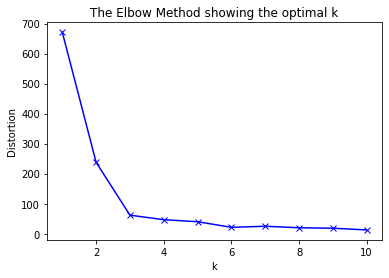

In [59]:
elbowPlot(10, X_treino, 10)

### Verificação de número de clusteres para tarefa proposta pelo grupo

Mean  1 :  633.17816079293
Mean  2 :  267.3999944559566
Mean  3 :  162.96030321181266
Mean  4 :  119.7237668513917
Mean  5 :  92.71803097967327
Mean  6 :  81.78496637066716
Mean  7 :  49.51141922840136
Mean  8 :  33.879714174783246
Mean  9 :  33.77113025679962
Mean  10 :  28.090336266000044


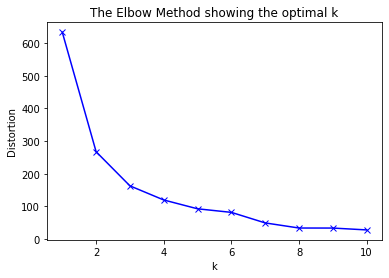

In [60]:
elbowPlot(10, W_treino, 10)

### Treinamento do Modelo K-Means

[-0.49459155 -0.41977353]
[1.64029747 0.44926385]
[-1.4341651   0.66652319]


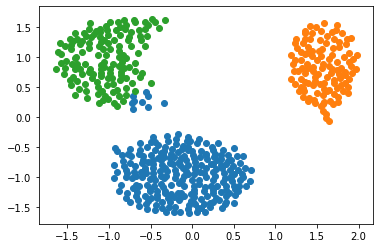

[-0.09429986 -0.98706182]
[1.56246297 0.82343272]
[-1.06167144  0.91395744]


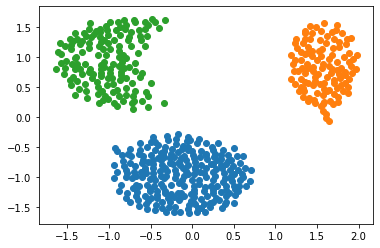

[-0.09429986 -0.98706182]
[1.56246297 0.82343272]
[-1.06167144  0.91395744]


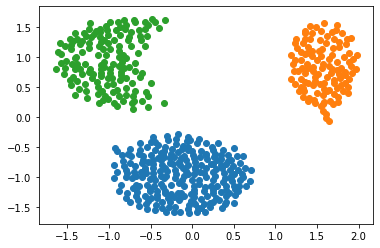

[-0.09429986 -0.98706182]
[1.56246297 0.82343272]
[-1.06167144  0.91395744]


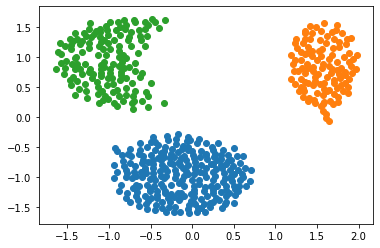

[-0.09429986 -0.98706182]
[1.56246297 0.82343272]
[-1.06167144  0.91395744]


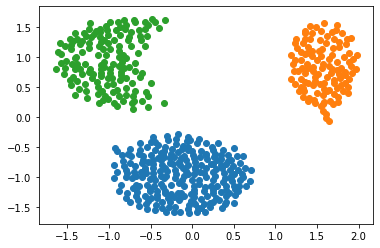

[-0.09429986 -0.98706182]
[1.56246297 0.82343272]
[-1.06167144  0.91395744]


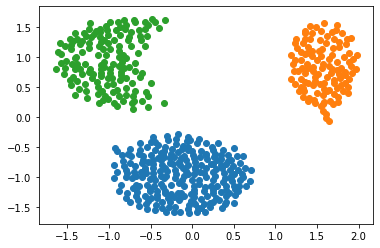

[-0.09429986 -0.98706182]
[1.56246297 0.82343272]
[-1.06167144  0.91395744]


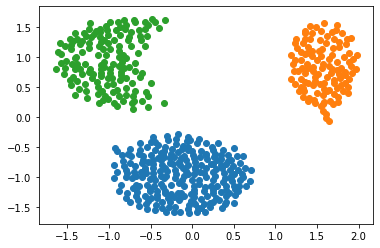

[-0.09429986 -0.98706182]
[1.56246297 0.82343272]
[-1.06167144  0.91395744]


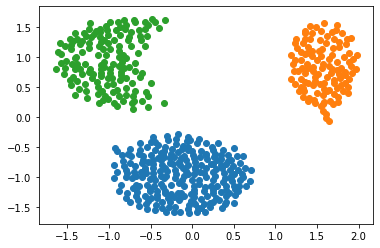

[-0.09429986 -0.98706182]
[1.56246297 0.82343272]
[-1.06167144  0.91395744]


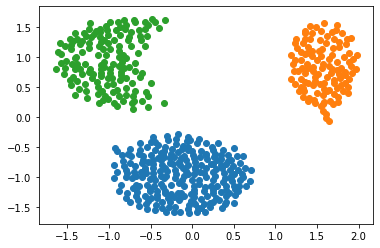

[-0.09429986 -0.98706182]
[1.56246297 0.82343272]
[-1.06167144  0.91395744]


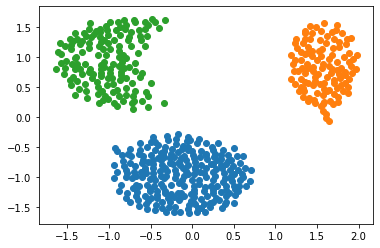

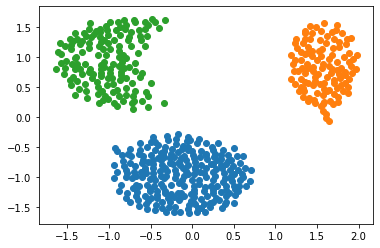

In [61]:
X_centroids, clusterMap = kmeans(3,X_treino, 10)

[-0.82839089 -1.10982432 -0.3162486  -1.04947918  0.08835836 -0.39275127
 -0.94299548  2.16066901 -2.06903418 -0.77347401  1.28351841 -1.33007677
 -0.21302116]
[ 0.49334262  2.03199669  1.80384913  1.65308575  0.86070511 -0.50491447
 -1.07351116 -0.74014117 -0.84257529  1.488867   -1.26113805 -0.97696606
 -0.37224585]
[ 0.19687903  0.02123125  1.10933436 -0.2687382   0.08835836  0.80899739
  1.21553297 -0.49840699  2.13596773  0.26901965  0.31830389  0.78858745
  1.39514818]


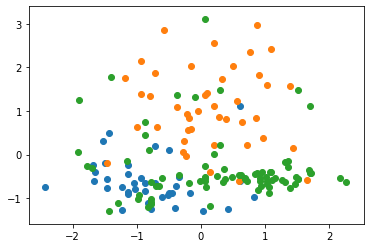

[-1.13720713 -0.45453022 -0.17003496 -0.2987667  -1.31590845 -1.11380046
 -0.53136913  1.27431034  0.0860293  -1.14980989  0.53767082 -0.48261108
 -0.84991991]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]


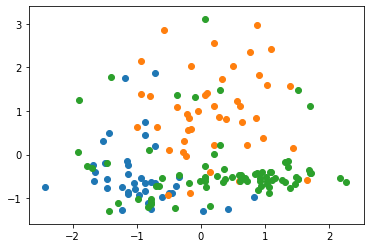

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]


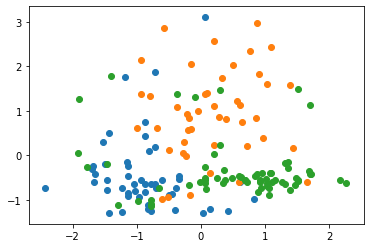

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]


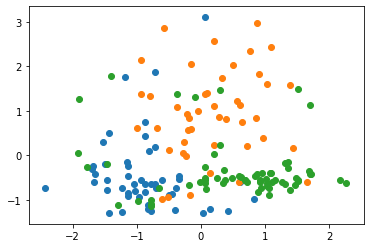

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]


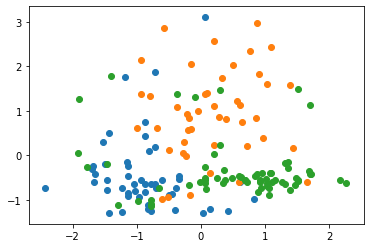

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]


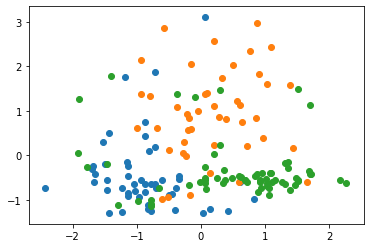

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]


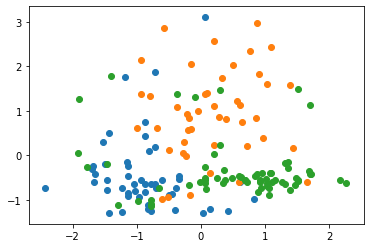

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]


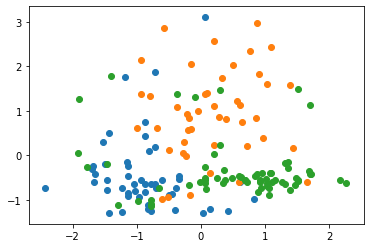

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]


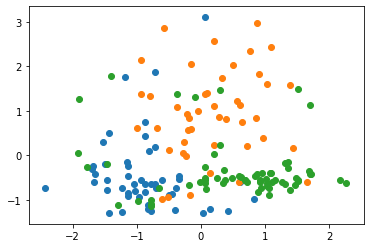

[-9.27212090e-01 -5.44296535e-01 -9.01103141e-01 -1.48624201e-01
 -1.38612179e+00 -1.03368389e+00  7.33234123e-04  6.56394314e-02
  6.85084581e-02 -7.17239912e-01  1.86683727e-01  7.88587455e-01
 -7.54385098e-01]
[ 0.39452142  0.81117481  0.0492855   0.60208828 -0.5435617  -0.58503105
 -1.2743045   0.71026392 -0.59728351  1.4542614  -1.78761869 -1.40069891
 -0.30855597]
[ 0.59216382 -0.47248348  0.15894572  0.30180329  0.01814502  0.64876424
  0.95450162 -0.82071924  0.47148781  0.01812906  0.36217728  1.2123203
  0.55125733]


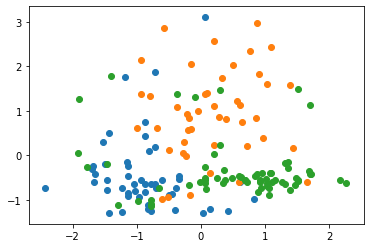

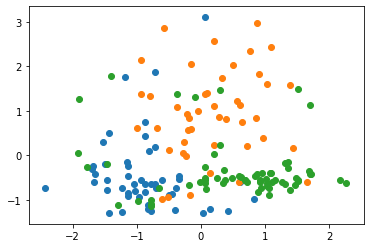

In [62]:
W_centroids, clusterMap = kmeans(3,W_treino, 10)

### Treinamento do Modelo Agglometrative Hierarchical Clustering


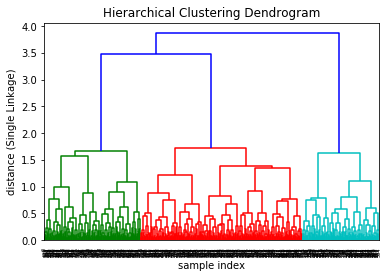

{0: 1028,
 1: 1028,
 2: 1028,
 3: 1028,
 4: 1028,
 5: 1028,
 6: 1028,
 7: 1028,
 8: 1028,
 9: 1028,
 10: 1028,
 11: 1028,
 12: 1028,
 13: 1028,
 14: 1028,
 15: 1028,
 16: 1028,
 17: 1028,
 18: 1028,
 19: 1028,
 20: 1028,
 21: 1028,
 22: 1028,
 23: 1028,
 24: 1028,
 25: 1028,
 26: 1028,
 27: 1028,
 28: 1028,
 29: 1028,
 30: 1028,
 31: 1028,
 32: 1028,
 33: 1028,
 34: 1028,
 35: 1028,
 36: 1028,
 37: 1028,
 38: 1028,
 39: 1028,
 40: 1028,
 41: 1028,
 42: 1028,
 43: 1028,
 44: 1028,
 45: 1028,
 46: 1028,
 47: 1028,
 48: 1028,
 49: 1028,
 50: 1028,
 51: 1028,
 52: 1028,
 53: 1028,
 54: 1028,
 55: 1028,
 56: 1028,
 57: 1028,
 58: 1028,
 59: 1028,
 60: 1028,
 61: 1028,
 62: 1028,
 63: 1028,
 64: 1028,
 65: 1028,
 66: 1028,
 67: 1028,
 68: 1028,
 69: 1028,
 70: 1028,
 71: 1028,
 72: 1028,
 73: 1028,
 74: 1028,
 75: 1028,
 76: 1028,
 77: 1028,
 78: 1028,
 79: 1028,
 80: 1028,
 81: 1028,
 82: 1028,
 83: 1028,
 84: 1028,
 85: 1028,
 86: 1028,
 87: 1028,
 88: 1028,
 89: 1028,
 90: 1028,
 91: 1028

In [65]:
# Adicionar treinamento para a tarefa 2D
agglomerativeHierarchicalCluster(X_treino, 1, "complete")

In [ ]:
# Adicionar treinamento para a tarefa dos vinhos
agglomerativeHierarchicalCluster(W_treino, 1, "complete")

### Testando Modelo K-Means


In [ ]:
kmeans(3,X_teste, 10, 'test', X_centroids)

In [ ]:
kmeans(3,W_teste, 10, 'test', W_centroids)
#aqui podemos calcular a taxa de acerto do modelo

### Testando Modelo Agglomerative Hierarchical Clustering

In [ ]:
# Adicionar teste dos dados da tarefa 2D

In [ ]:
# Adicionar teste dos dados da tarefa dos vinhos

## Parte 2 - Redução de Dimensionalidade
Utilizamos o método PCA para reduzir a dimensionalidade da tarefa escolhida pelo grupo, e comparamos o efeito de aplicar o K-Means em um conjunto de dados sem redução de dimensionalidade e outro com redução de dimensionalidade.
Realizamos as seguintes tarefas:
<ul>
    <li>Rodamos o PCA nos dados, utilizando 3 energias (variâncias) diferentes para reduzir a dimensionalidade</li>
    <li>Rodamos o K-Means com diferentes números de clusteres</li>
    <li>Comparamos os resultados com os obtidos na Parte 1</li>
</ul>


### Rodando o PCA
Realizamos a análise de dimensionalidade utilizando-se dos dados de treino do dataset de vinhos, e obervarmos as propriedades mais relevantes para classificação dos itens.

Primeiramente, montamos um gráfico para explicar quais componentes principais são mais percentualmente relevantes à representação, ou seja, quais componentes explicam melhor nossos dados.


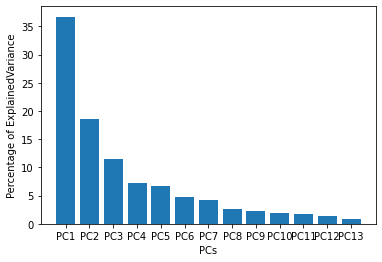

In [20]:
pca = PCA()
pca_data = pca.fit_transform(W_treino)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ["PC" + str(i) for i in range(1, 14)]

plt.bar(x=range(1, 14), height=per_var, tick_label=labels)
plt.ylabel('Percentage of ExplainedVariance')
plt.xlabel('PCs')
plt.show()


Em seguida, montamos um dataFrame para organizar nossos dados e observar a projeção das componentes em apenas duas dimensões, para que seja mais fácil de avaliar suas relevâncias e similaridades.

É importante observar que features mais distantes da origem têm maior influência sobre os dados, como também, features próximas umas das outras nos revelam similaridade entre as mesmas.

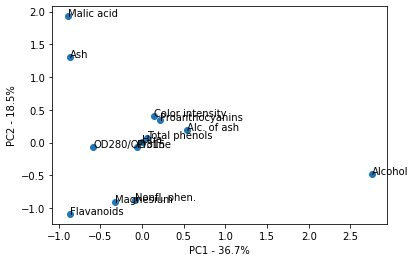

In [13]:
wine_labels = ['Alcohol', 'Malic acid', 'Ash', 'Alc. of ash', 'Magnesium', 'Total phenols', \
              'Flavanoids', 'Nonfl. phen.', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315',\
              'Proline']
pca_df = pd.DataFrame(pca_data.T, index=wine_labels)


plt.scatter(pca_df[0], pca_df[1])
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for idx in pca_df.index:
    plt.annotate(idx, (pca_df[0].loc[idx], pca_df[1].loc[idx]))

plt.show()

### Escolher 3 variâncias
Variância 1: PC1, PC2 e PC3 com 66.52% de representatividade <br>
Variância 2: PC1, PC2, PC3, PC4 e PC5 com 80.16% de representatividade <br>
Variância 3: PC1, PC2, PC3, PC4, PC5, PC6 e PC7 com 89.33% de representatividade <br>

Mean  1 :  461.36927981488753
Mean  2 :  129.20808311927868
Mean  3 :  82.81307221013326
Mean  4 :  67.48311149366211
Mean  5 :  37.840071250201916
Mean  6 :  22.656019221257687
Mean  7 :  23.694825310064594
Mean  8 :  22.683253532348257
Mean  9 :  17.276053680809266
Mean  10 :  19.540847999878693


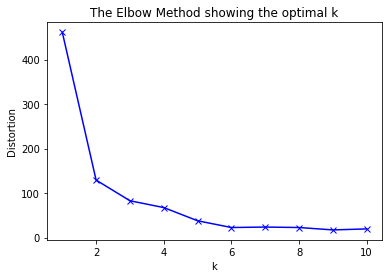

In [32]:
energy1 = 3
energy2 = 5
energy3 = 7

cluster_energy1 = []
cluster_energy2 = []
cluster_energy3 = []

elbowPlot(10, pca_data[:,:energy1])


## Discussão
<ul>
    <li>Como/se a normalização afetou nossos reultados</li>
    <li>Se o número de clusteres encontrado representa bem nossos dados</li>
    <li>Como/se a inicialização de "centroides" afeta a solução</li>
    <li>As desvantagens de cada método</li>
    <li>Como a redução de dimensionalidade afetou seus resultados</li>
</ul>